# Bayes rule and internal consistency

Bayesianists interpret probabilities as subjective opinions that depend on the background knowledge. As such, the question whether statistical inference produces results that are consistent with other theories is ill-posed – if a person does not believe the base results of a theory, his or her posterior does not have to match the predictions of the theory.

However, the inference must still adhere to internal consistency. That is, we should always get the same results if we rephrase the problem in different but equivalent ways. The following examples about coinflipping show that the Bayes theorem satisfies this restriction.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import numpy.random as rnd

from pandas import Series
from pandas import DataFrame
from typing import List

from tqdm import tnrange
from plotnine import *

# Local imports
from common import *
from convenience import *

# Homework

## 7.1  Belief update for a single observation and for multiple observations (<font color='red'>1p</font>)

Let us consider a coin with bias $\alpha$, i.e., $\Pr[B_i =1|\alpha]=\alpha$ and $\Pr[B_i = 0|\alpha]=1-\alpha$.
Describe how the initial beliefs must change if we observe a single coinflip $B_1$ or several coinflips $B_1,\ldots,B_n$. Define two belief update functions `update_beliefs_1` and `update_beliefs_2` which implement these rules.    

In [2]:
prior = (DataFrame({'alpha': np.linspace(0, 1, num = 11, endpoint=True)}).
      assign(pr = 1/11))
prior

,alpha,pr
0,0.0,0.090909
1,0.1,0.090909
2,0.2,0.090909
3,0.3,0.090909
4,0.4,0.090909
5,0.5,0.090909
6,0.6,0.090909
7,0.7,0.090909
8,0.8,0.090909
9,0.9,0.090909


In [3]:
b=0
(prior
 .assign(likelihood = lambda df: df['alpha']**b*(1-df['alpha'])**(1-b))
 .assign(posterior = lambda df: df['pr'] * df['likelihood'])
 .assign(pr = lambda df: df['posterior']/df['posterior'].sum())
 [['alpha', 'pr']]
)

,alpha,pr
0,0.0,0.181818
1,0.1,0.163636
2,0.2,0.145455
3,0.3,0.127273
4,0.4,0.109091
5,0.5,0.090909
6,0.6,0.072727
7,0.7,0.054545
8,0.8,0.036364
9,0.9,0.018182


In [4]:
def update_beliefs_1(prior: DataFrame, b: int) -> DataFrame:
    return (prior
            .assign(likelihood = lambda df: df['alpha']**b*(1-df['alpha'])**(1-b))
            .assign(posterior = lambda df: df['pr'] * df['likelihood'])
            .assign(pr = lambda df: df['posterior']/df['posterior'].sum())
            [['alpha', 'pr']])

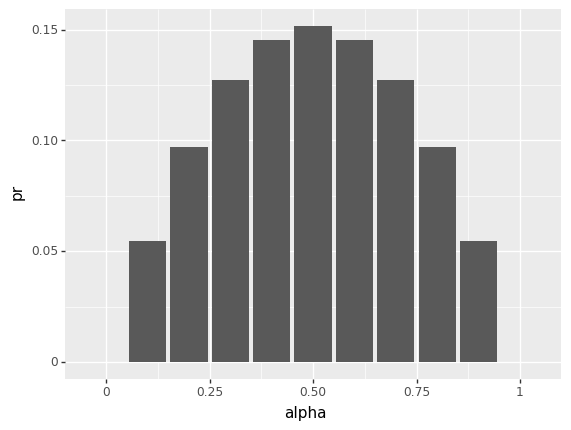

<ggplot: (682574746)>

In [5]:
ggplot(update_beliefs_1(update_beliefs_1(prior, 1), 0)) + geom_col(aes(x='alpha', y='pr'))

In [6]:
def update_beliefs_2(prior: DataFrame, B: List[int]) -> DataFrame:
    k = sum(B)
    n = len(B)
    return (prior
            .assign(likelihood = lambda df: df['alpha']**k*(1-df['alpha'])**(n-k))
            .assign(posterior = lambda df: df['pr'] * df['likelihood'])
            .assign(pr = lambda df: df['posterior']/df['posterior'].sum())
            [['alpha', 'pr']])

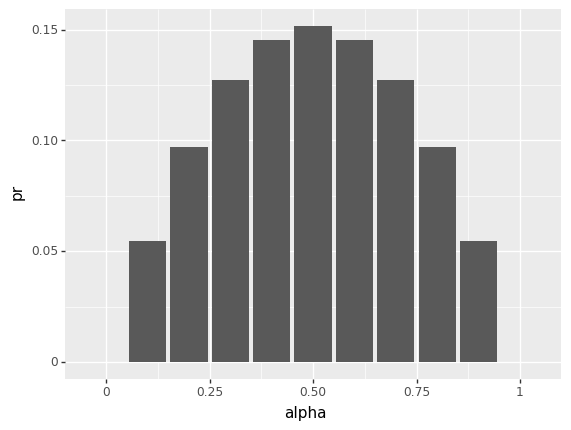

<ggplot: (682751245)>

In [7]:
ggplot(update_beliefs_2(prior, [1, 0])) + geom_col(aes(x='alpha', y='pr'))

## 7.2 Internal consistency of belief update rules (<font color='red'>1p</font>)

Given a set of observations $B_1,\ldots,B_n$, we can update our beliefs by observing a single $B_i$ at a time or update our beliefs by considering all observations at once. The first corresponds to an iterative application of `update_beliefs_1` and the second to a single update with `update_beliefs_2`. Show experimentally that both strategies give the same result by testing this on 10 different observation vectors of length 15 and on two different prior assignments over the grid $\{0.0, 0.1,\ldots, 1.0\}$.

## 7.3 External consistency for infinite observers (<font color='red'>1p</font>)
Although orthodox Bayesianism excludes the question of correctness, we can still experiment whether our posterior distribution converges to the true value given enough observations. Let the true value of $\alpha$ be $0.5$. Consider a uniform prior and a sceptical prior $\Pr[\alpha=0.1] = 0.455$, $\Pr[\alpha=0.9] = 0.455$,
$\Pr[\alpha=0.0] =\ldots=\Pr[\alpha=1.0]= 0.01$. Draw $1024$ samples and compute posterior distributions after observing $4$, $16$, $64$, $256$, $1024$ samples. Interpret results.

**Extra point:** Let the closeness of the posterior with the true answer $\alpha=0.5$ be measured as $\delta=1-\Pr[\alpha=0.5|B_1,\ldots,B_{N}]$. Visualise the random nature of the convergence to the true value by plotting the $\delta$ values for $100$ experiments and draw lower $5\%$ quantiles.   

In [8]:
orth_prior = (DataFrame({'alpha': np.linspace(0, 1, num = 11, endpoint=True)})
      .assign(pr = lambda df: df['alpha'].isin([0.1,0.9]) * 0.455 + ~df['alpha'].isin([0,1]) * 0.01)
      .assign(pr = lambda df: df['pr']/df['pr'].sum()))
orth_prior

,alpha,pr
0,0.0,0.000
1,0.1,0.465
2,0.2,0.010
3,0.3,0.010
4,0.4,0.010
5,0.5,0.010
6,0.6,0.010
7,0.7,0.010
8,0.8,0.010
9,0.9,0.465


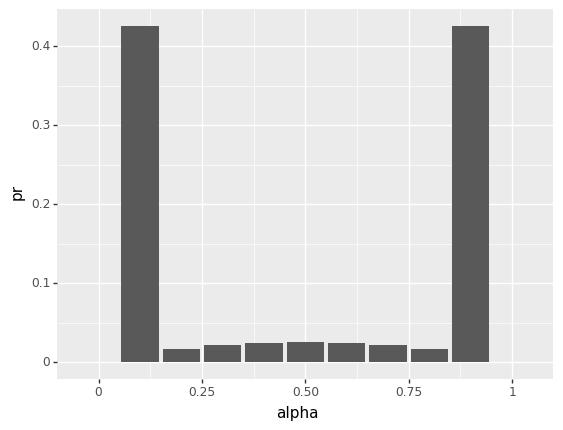

<ggplot: (682787247)>

In [9]:
ggplot(update_beliefs_2(orth_prior, [1, 0])) + geom_col(aes(x='alpha', y='pr'))

## 7.4 Minimal information needed to infer coin bias* (<font color='red'>1p</font>)

The block belief update rule `update_beliefs_2` takes in a vector of observations. Show that this informaation can be reduced to the number of ones $k$ and the number of coin tosses. For that, show that the block belief update rule will always lead to the same posterior for all observations of $n$ coin tosses with $k$ ones. Are there any other partial observations with the same property? 

## 7.5 Laws of probabilities and internal consistency** (<font color='red'>3p</font>)

Let us consider the following scheme for betting:
* You can buy and sell tickets for all kinds of events. 
* Let $p[X]$ be the price you are willing to pay for the ticket $X$.   
* If the event $X$ occurs and you have the ticket $X$, you get $1$ euro.
* You can buy the ticket for `True` with price $1$ euro as you always get $1$ euro for it.

You behaviour is rational if 
* The set of tickets $\mathcal{A}$ and $\mathcal{B}$ represent the same event if you get the same amount of money for both sets, no matter what occurs.  
* You are **rational** if you always pay the same amount of money for the tickets that represent the same event.
* You are **irrational** if you accept a set of tickets for the price that is smaller than what you can gain for any outcome.

Prove that if you are rational, then:
* Your pricing function $p[\cdot]$ satisfies the laws of probability. (**<font color='red'>1p</font>**)
* The Bayes theorem must hold. For that, you have to consider two-stage betting. (**<font color='red'>2p</font>**)